# General

**Available traffic count data:**
- BAST traffic count for whole Germany (2003 until 2018) [Map BAST stations Germany](https://tumde-my.sharepoint.com/:b:/g/personal/johannes_gensheimer_tum_de/EdDBb-siKZZIvjM8kKd5olIBrPItB3HQSb1ywU1tE6uhyA?e=5wtxzx)
- BAYSIS traffic count data for Bavaria (2017 until April 2020) [Map BASIS stations Germany](https://tumde-my.sharepoint.com/:b:/g/personal/johannes_gensheimer_tum_de/EdUoyfWh8GtLi3qA_hgaZjgBUpgirz1mRd0ZUiAI5OKQLw?e=klBvtc)\
    --> BAYSIS is acutally also included in BAST but much more recent data is available for BAYSIS \

**Available Corona Mobility reports:**
- BAST: weekly values for 03/2020 until 06/2020 referenced to the time frame 02/02/2020 until 03/07/2020 for traffic decrease for whole Germany
- Apple: daily values of the decrease in route requests for Germany and sub regions referenced to 01/13/2020
- TomTom: daily values of traffic congestion for 25 cities in Germany in relation to the correlated day in 2019
- Google: daily values where people are referenced to the median of 01/03/2020 - 02/06/2020

**Why is it necessary to estimate the traffic of Germany?**
- no continuous data for traffic in Germany
- reference value of mobility reports is not available (no traffic count data for whole Germany)
- there is a seasonal cycle in traffic in Germany so e.g. the mobility report of BAST references to 02/2020 but for this timeframe no traffic count data is available for whole Germany 

--> we have to create this reference data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

plt.rcParams.update({'font.size':18})

## Read dataframes
Monthly data for traffic count for Germany and Bavaria. Bavaria data is retrieved from BAST dataset. \
Time span: 01/2003 - 12/2018

In [2]:
df_Bast = pd.read_csv('../data/mobility/BAST_CountingStations_Feature_monthly.csv',index_col='date')
df_BastBay = pd.read_csv('../data/mobility/BAST_Bavaria_CountingStations_Feature_monthly.csv',index_col='date')

In [3]:
df = pd.concat([df_Bast, df_BastBay],axis=1)

In [4]:
df.head()

,M_BAST_AverTotalVehicPerCountingStation,M_BAST_Bavaria_AverTotalVehicPerCountingStation
date,,
2003-01,9.249844e+05,1.175458e+06
2003-02,9.057583e+05,1.161299e+06
2003-03,1.043931e+06,1.350965e+06
2003-04,1.059928e+06,1.359519e+06
2003-05,1.088547e+06,1.385195e+06


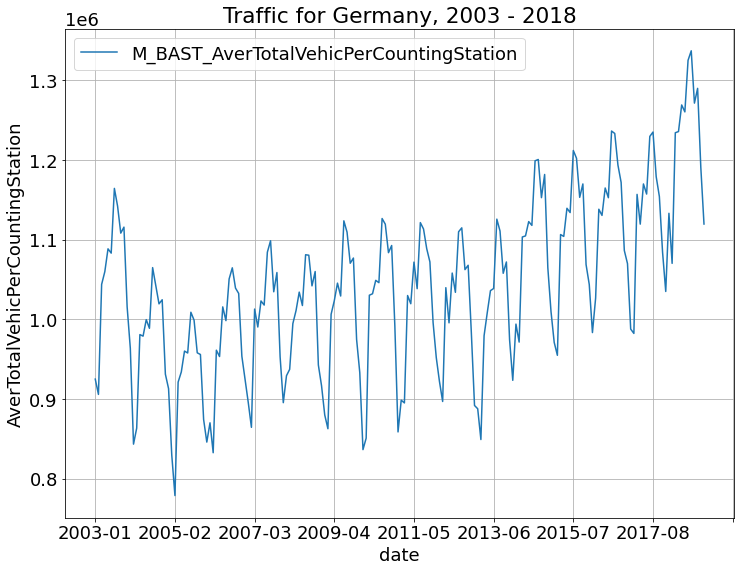

In [5]:
df_Bast.plot(figsize=(12,9))
plt.title('Traffic for Germany, 2003 - 2018')
plt.ylabel('AverTotalVehicPerCountingStation')
plt.grid()

### Seasonal cycle in one year (2018, whole Germany)

Text(0.5, 1.0, 'Average total number of vehicles \nper counting station in Germany for 2018')

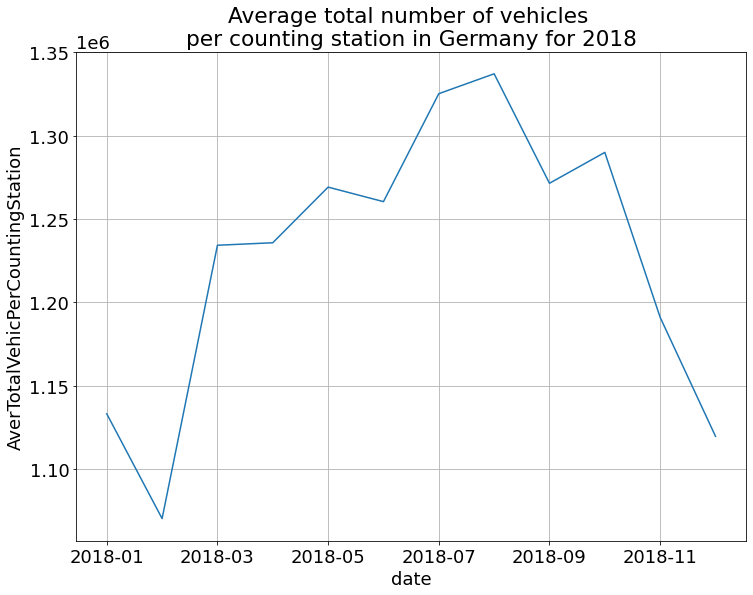

In [6]:
df_2018 = df[df.index >= '2018-01']
df_2018.M_BAST_AverTotalVehicPerCountingStation.plot(figsize=(12,9))
plt.grid()
plt.ylabel('AverTotalVehicPerCountingStation')
plt.title('Average total number of vehicles \nper counting station in Germany for 2018')

### Investigate seasonal deviation of year relative to Feb 2018

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0.5, 1.0, 'Seasonal monthly deviation from Feb year')

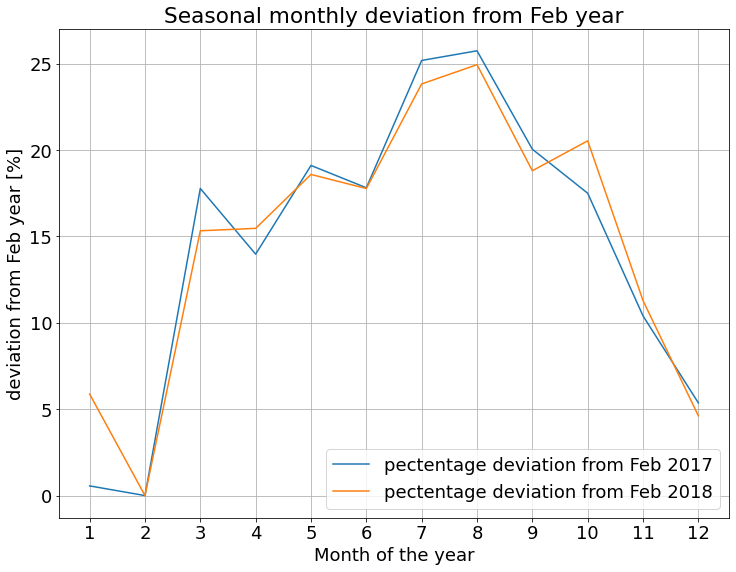

In [33]:
df_2017 = df[df.index >= '2017-01']
df_2017 = df_2017[df_2017.index < '2018-01']
ref_value = df_2017.M_BAST_AverTotalVehicPerCountingStation['2017-02']
df_2017['PercentageDeviationFromFeb2017'] = 100 * (df_2017.M_BAST_AverTotalVehicPerCountingStation-ref_value) / ref_value

df_2018 = df[df.index >= '2018-01']
ref_value = df_2018.M_BAST_AverTotalVehicPerCountingStation['2018-02']
df_2018['PercentageDeviationFromFeb2018'] = 100 * (df_2018.M_BAST_AverTotalVehicPerCountingStation-ref_value) / ref_value

fig,ax = plt.subplots(figsize=(12,9))
plt.plot(np.arange(1,13), df_2017.PercentageDeviationFromFeb2017, label='pectentage deviation from Feb 2017')
plt.plot(np.arange(1,13), df_2018.PercentageDeviationFromFeb2018, label='pectentage deviation from Feb 2018')
#df_2018.PercentageDeviationFromFeb2018.plot(figsize=(12,9))
plt.grid()
plt.ylabel('deviation from Feb year [%]')
plt.xlabel('Month of the year')
plt.xticks(np.arange(1,13))
plt.legend()
plt.title('Seasonal monthly deviation from Feb year')

## Compare traffic in Germany with traffic in Bavaria

Text(0, 0.5, 'AverTotalVehicPerCountingStation')

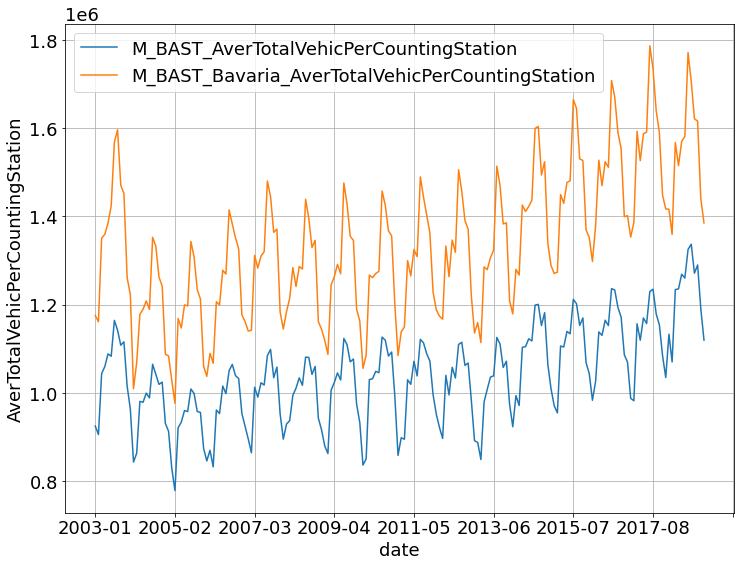

In [8]:
df.plot(figsize=(12,9))
plt.grid()
plt.ylabel('AverTotalVehicPerCountingStation')

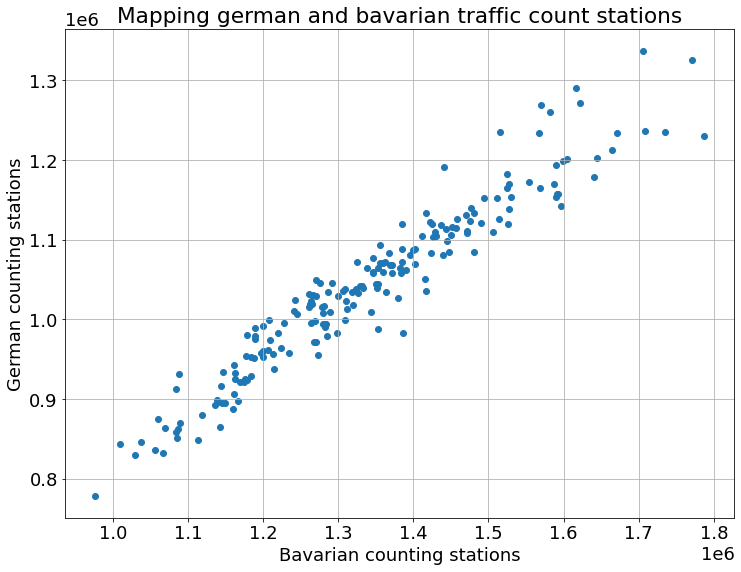

In [9]:
plt.figure(figsize=(12,9))
plt.scatter(df.M_BAST_Bavaria_AverTotalVehicPerCountingStation, df.M_BAST_AverTotalVehicPerCountingStation)
plt.xlabel('Bavarian counting stations')
plt.ylabel('German counting stations')
plt.title('Mapping german and bavarian traffic count stations')
plt.grid()
plt.savefig('ComparisonGermanAndBavarianStations.png')
plt.savefig('ComparisonGermanAndBavarianStations.eps', format='eps')

## Mapping
Based on the above plots it is obvious that the traffic count data of Germany and the one of Bavaria is lineary correlated. --> Linear Regression

In [10]:
lr = LinearRegression()

#split data randomly (75% training, 25% testing)
X_train, X_test, y_train, y_test = train_test_split(df.M_BAST_Bavaria_AverTotalVehicPerCountingStation.values.reshape(-1, 1), df.M_BAST_AverTotalVehicPerCountingStation, test_size = 0.25)

lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [11]:
y_pred_test = lr.predict(X_test.reshape(-1, 1))
r2 = round(lr.score(X_test.reshape(-1, 1), y_test),2)
rmse = round(sqrt(mean_squared_error(y_test, y_pred_test)),2)
print('r2: ', r2)
print('rmse: ', rmse)


r2:  0.92
rmse:  30468.28


In [12]:
# rmse related to mean traffic for time span 2003 - 2018 to get percentage rmse
MeanTraffic = df.M_BAST_AverTotalVehicPerCountingStation.mean()
rmse_perc = round(100 * rmse/MeanTraffic,2)
print('RMSE related to mean traffic of Germany in %: ', rmse_perc, '%')


RMSE related to mean traffic of Germany in %:  2.92 %


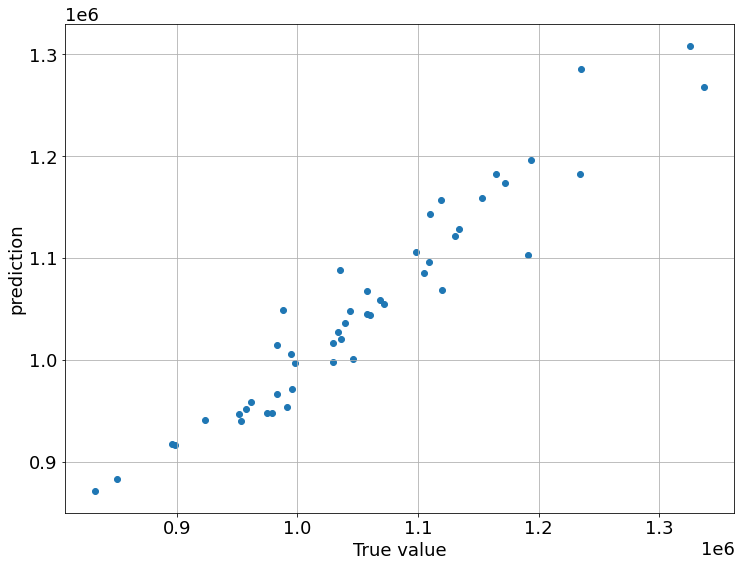

In [13]:
plt.figure(figsize=(12,9))
plt.scatter(y_test, y_pred_test)
plt.grid()
plt.xlabel('True value')
plt.ylabel('prediction')
plt.show()

## Train and test on whole dataset
The whole dataset of Bavaria is mapped on the dataset of Germany

In [14]:
lr = LinearRegression()
lr.fit(df.M_BAST_Bavaria_AverTotalVehicPerCountingStation.values.reshape(-1, 1), df.M_BAST_AverTotalVehicPerCountingStation)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

R2 and RMSE for whole dataset
r2:  0.92
rmse:  29828.37


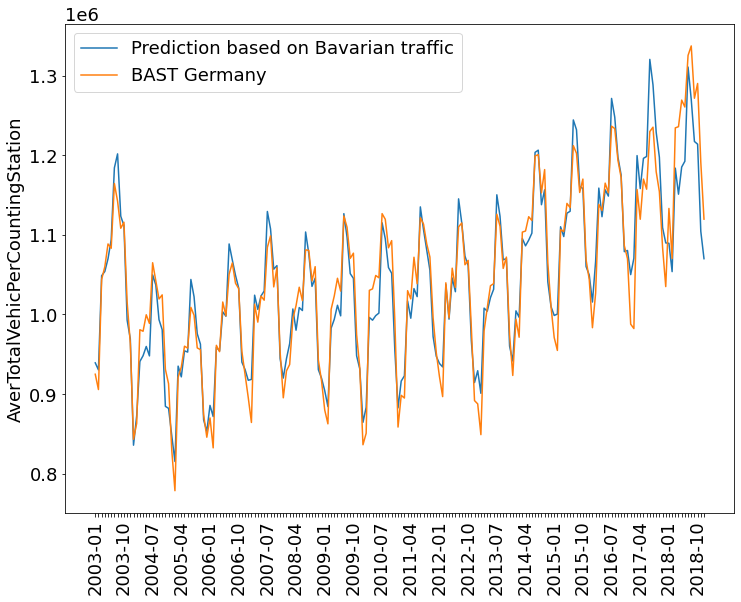

In [15]:
#training lr for 2019, 2020
PredGerBASTBavariaAllData = lr.predict(df.M_BAST_Bavaria_AverTotalVehicPerCountingStation.values.reshape(-1, 1))

print('R2 and RMSE for whole dataset')
r2 = round(lr.score(df.M_BAST_Bavaria_AverTotalVehicPerCountingStation.values.reshape(-1, 1), df.M_BAST_AverTotalVehicPerCountingStation),2)
rmse = round(sqrt(mean_squared_error(df.M_BAST_AverTotalVehicPerCountingStation, PredGerBASTBavariaAllData)),2)
print('r2: ', r2)
print('rmse: ', rmse)


fig,ax = plt.subplots(figsize=(12,9))
plt.plot(PredGerBASTBavariaAllData, label='Prediction based on Bavarian traffic')
plt.plot(df.M_BAST_AverTotalVehicPerCountingStation, label='BAST Germany')
#ax = sns.pointplot(x=df.index, y=PredGerBASTBavariaAllData, label='pred')
#ax = sns.pointplot(x=df.index, y=df.M_BAST_AverTotalVehicPerCountingStation, label='pred', color='red')

#ax = fig.axes
plt.legend()
#plt.xticks(rotation=90)
#plt.grid()
max_ticks = 20
x_values = np.array(df.index.values)
if len(x_values) > max_ticks:
    ticks_spacing = int(len(x_values)/max_ticks)
    ticks = ax.get_xticklabels()
for label in ax.get_xticklabels()[::1]:
    label.set_visible(False)
for label in ticks[::ticks_spacing]:
    label.set_visible(True)
    
plt.xticks(rotation=90)
plt.ylabel('AverTotalVehicPerCountingStation')
plt.show()

## Include most recent traffic count data of Bavaria (BAYSIS)
First predict 2019 and 2020 based on LR

In [16]:
#read Baysis data for 2017 until 2020
df_Baysis = pd.read_csv('../data/mobility/Baysis_CountingStations_Feature_monthly.csv', index_col='date')

In [17]:
#calculate traffic of Germany based on Baysis (Bavarian) data
df_Baysis['PredGermany'] = lr.predict(df_Baysis.M_BaysisCount_AverTotalVehicPerCountingStation.values.reshape(-1, 1))

## Comparison of 
- Bavaria BAST predicted values for Germany
- Bavaria BAYSIS predicted values for Germany
- real BAST traffic count

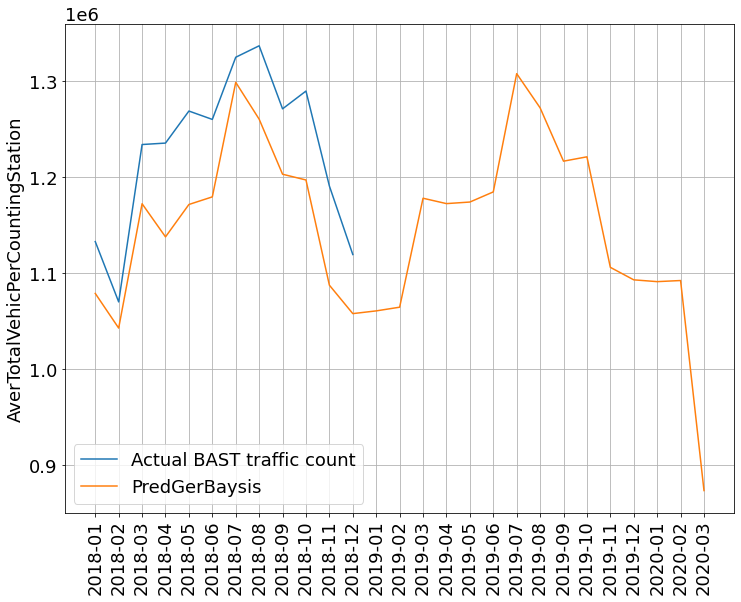

In [35]:
plt.figure(figsize=(12,9))
#plt.plot(df.index[-12:], PredGerBASTBavariaAllData[-12:], label='PredGerBavariaBAST')
plt.plot(df.index[-12:], df.M_BAST_AverTotalVehicPerCountingStation[-12:], label='Actual BAST traffic count')
plt.plot(df_Baysis.index[-28:-1], df_Baysis.PredGermany[-28:-1], label='PredGerBaysis')
#plt.plot(df_BAST_MR.index[-6:], df_BAST_MR.M_BASTMobRep_DiffRatio[-6:], label='PredGerBAST_MR')
plt.ylabel('AverTotalVehicPerCountingStation')
plt.xticks(rotation=90)
plt.legend()
plt.grid()

## Investigation of BAST mobility report
### Read BAST mobility report
Percentage deviation to the base 02/2020 

Text(0.5, 1.0, 'Mobility report Corona BAST')

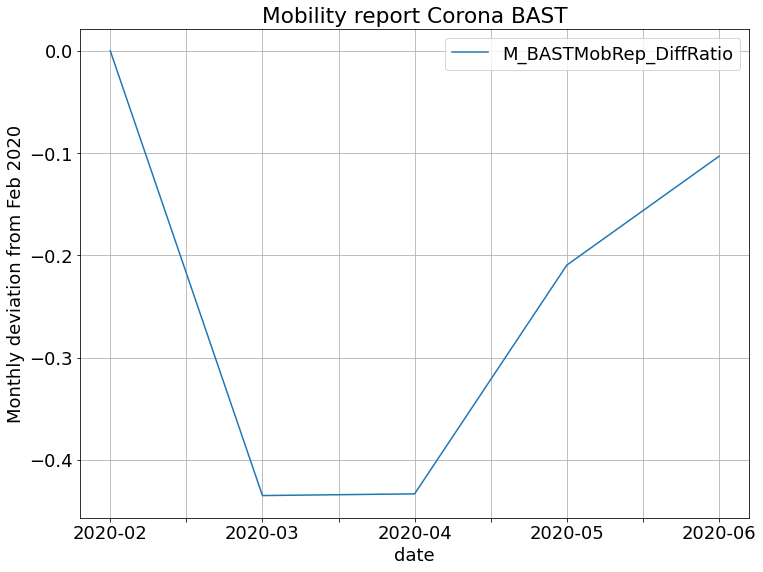

In [19]:
df_Bast_MR = pd.read_csv('../data/mobility/BASTMobilityReport_monthly.csv',index_col='date')

df_tmp = pd.DataFrame({'M_BASTMobRep_DiffRatio':0}, index=['2020-02'])
df_tmp.index.name = 'date'
df_Bast_MR = df_Bast_MR.append(df_tmp)
df_Bast_MR = df_Bast_MR.sort_index()
#print(df_Bast_MR.head())
df_Bast_MR.plot(figsize=(12,9))
plt.grid()
plt.ylabel('Monthly deviation from Feb 2020')
plt.title('Mobility report Corona BAST')


## Caculate months April, May and June 2020 using the BAST mobility report

In [20]:
#read BAST mobility report
df_BAST_MR = pd.read_csv('../data/mobility/BASTMobilityReport_monthly.csv', index_col='date')
df_BAST_MR.M_BASTMobRep_DiffRatio  = df_Baysis.PredGermany['2020-02'] * (1 + df_BAST_MR.M_BASTMobRep_DiffRatio)

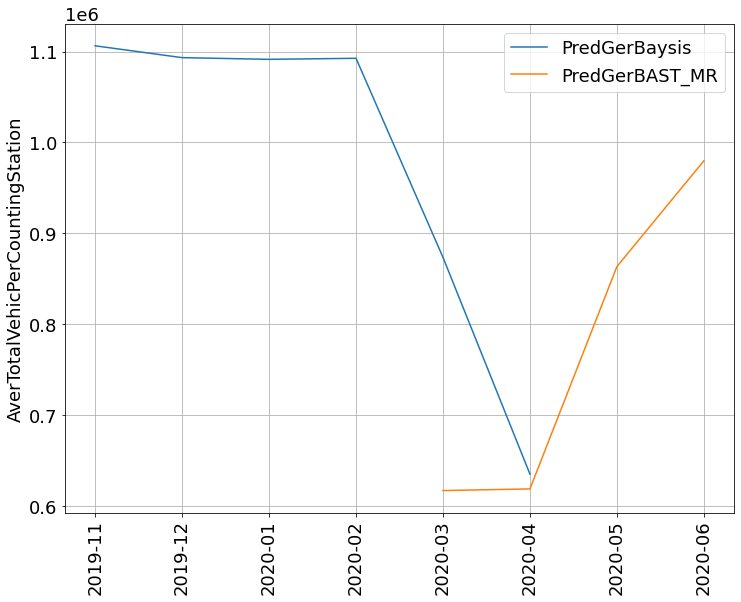

In [21]:
plt.figure(figsize=(12,9))
plt.plot(df_Baysis.index[-6:], df_Baysis.PredGermany[-6:], label='PredGerBaysis')
plt.plot(df_BAST_MR.index[-6:], df_BAST_MR.M_BASTMobRep_DiffRatio[-6:], label='PredGerBAST_MR')
plt.ylabel('AverTotalVehicPerCountingStation')
plt.xticks(rotation=90)
plt.legend()
plt.grid()

***Why the lines do not match in 03/2020*** \
The lines do not match in March 2020 because in the Mobility report only the time span of 03/18/2020 - 03/31/2020 is available. So there is no information about the first half of the month. \n 
--> taking the value of the prediction based on the Baysis dataset and not the BAST mobility report for 03/2020

In [22]:
df_Baysis = df_Baysis.drop('M_BaysisCount_AverTotalVehicPerCountingStation', axis=1)
df_BAST_MR = df_BAST_MR.rename(columns={'M_BASTMobRep_DiffRatio':'PredGermany'})

In [23]:
#one feature in this dataframe: 2017 until 2020 predicted traffic based on BAYSIS and BAST Mobility report
df_BAYSIS_BASTMR = pd.concat([df_Baysis.drop('2020-04',axis=0), df_BAST_MR.drop('2020-03',axis=0)])
df_BAYSIS_BASTMR.head()

,PredGermany
date,
2017-02,1.056517e+06
2017-03,1.181717e+06
2017-04,1.138311e+06
2017-05,1.176980e+06
2017-06,1.181064e+06


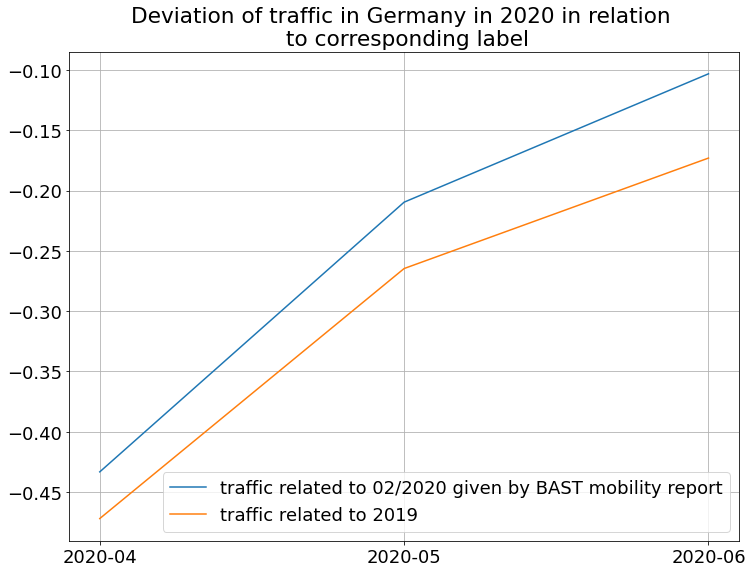

In [24]:
index = ['2020-03', '2020-04', '2020-05', '2020-06']
diff_20To19 = [df_BAYSIS_BASTMR.PredGermany['2020-03']/df_BAYSIS_BASTMR.PredGermany['2019-03'] - 1,
              df_BAYSIS_BASTMR.PredGermany['2020-04']/df_BAYSIS_BASTMR.PredGermany['2019-04'] - 1,
              df_BAYSIS_BASTMR.PredGermany['2020-05']/df_BAYSIS_BASTMR.PredGermany['2019-05'] - 1,
              df_BAYSIS_BASTMR.PredGermany['2020-06']/df_BAYSIS_BASTMR.PredGermany['2019-06'] - 1
              ]
diff_20To18 = [df_BAYSIS_BASTMR.PredGermany['2020-03']/df_BAYSIS_BASTMR.PredGermany['2018-03'] - 1,
              df_BAYSIS_BASTMR.PredGermany['2020-04']/df_BAYSIS_BASTMR.PredGermany['2018-04'] - 1,
              df_BAYSIS_BASTMR.PredGermany['2020-05']/df_BAYSIS_BASTMR.PredGermany['2018-05'] - 1,
              df_BAYSIS_BASTMR.PredGermany['2020-06']/df_BAYSIS_BASTMR.PredGermany['2018-06'] -1 
              ]
diff_20To17 = [df_BAYSIS_BASTMR.PredGermany['2020-03']/df_BAYSIS_BASTMR.PredGermany['2017-03'] - 1,
              df_BAYSIS_BASTMR.PredGermany['2020-04']/df_BAYSIS_BASTMR.PredGermany['2017-04'] - 1,
              df_BAYSIS_BASTMR.PredGermany['2020-05']/df_BAYSIS_BASTMR.PredGermany['2017-05'] - 1,
              df_BAYSIS_BASTMR.PredGermany['2020-06']/df_BAYSIS_BASTMR.PredGermany['2017-06'] -1 
              ]

val_BAST_MR = np.array(df_Bast_MR.M_BASTMobRep_DiffRatio[-4:])

plt.figure(figsize=(12,9))
plt.plot(index[-3:], val_BAST_MR[-3:], label='traffic related to 02/2020 given by BAST mobility report')
plt.plot(index[-3:], diff_20To19[-3:], label='traffic related to 2019')
#plt.plot(index[-3:], diff_20To18[-3:], label='traffic related to 2018')
#plt.plot(index[-3:], diff_20To17[-3:], label='traffic related to 2017')
plt.title('Deviation of traffic in Germany in 2020 in relation \n to corresponding label')
plt.legend()
plt.grid()

## Difference of BAST Mobility report and deviation of traffic to 2019

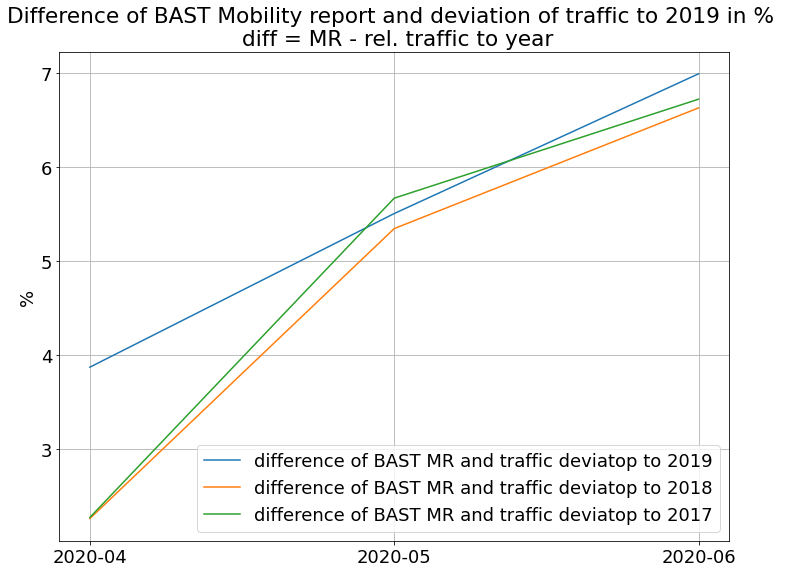

In [25]:
plt.figure(figsize=(12,9))
plt.plot(index[-3:], 100*(val_BAST_MR[-3:]-diff_20To19[-3:]), label='difference of BAST MR and traffic deviatop to 2019')
plt.plot(index[-3:], 100*(val_BAST_MR[-3:]-diff_20To18[-3:]), label='difference of BAST MR and traffic deviatop to 2018')
plt.plot(index[-3:], 100*(val_BAST_MR[-3:]-diff_20To17[-3:]), label='difference of BAST MR and traffic deviatop to 2017')
plt.title('Difference of BAST Mobility report and deviation of traffic to 2019 in % \n diff = MR - rel. traffic to year')
plt.ylabel('%')
plt.legend()
plt.grid()

## Time series for traffic in Germany starting from 2017

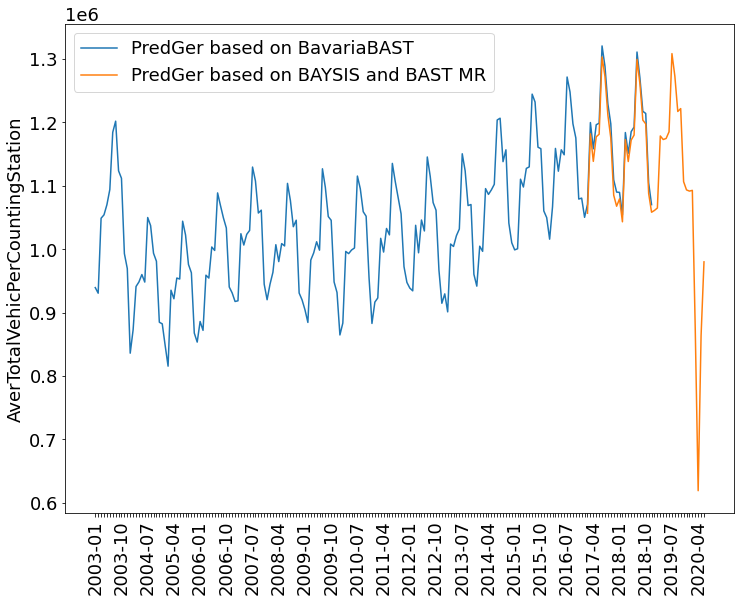

In [26]:
fig,ax = plt.subplots(figsize=(12,9))
plt.ylabel('AverTotalVehicPerCountingStation')
plt.plot(df.index, PredGerBASTBavariaAllData, label='PredGer based on BavariaBAST')
plt.plot(df_BAYSIS_BASTMR.index, df_BAYSIS_BASTMR.PredGermany, label='PredGer based on BAYSIS and BAST MR')
plt.xticks(rotation=90)
plt.legend()


max_ticks = 20
x_values = np.array(df.index.values)
if len(x_values) > max_ticks:
    ticks_spacing = int(len(x_values)/max_ticks)
    ticks = ax.get_xticklabels()
for label in ax.get_xticklabels()[::1]:
    label.set_visible(False)
for label in ticks[::ticks_spacing]:
    label.set_visible(True)
    

## Build feature dataset for traffic in Germany

In [27]:
df_BAST_Bavaria = pd.DataFrame({'PredGermany': PredGerBASTBavariaAllData}, index=df.index)
df_BAYSIS_BASTMR
df_feature = pd.concat([df_BAST_Bavaria, df_BAYSIS_BASTMR[df_BAYSIS_BASTMR.index > '2018-12']])
df_feature = df_feature.rename(columns={'PredGermany': 'M_KFZ'})
df_feature.head(300)

,M_KFZ
date,
2003-01,9.392795e+05
2003-02,9.304566e+05
2003-03,1.048648e+06
2003-04,1.053978e+06
2003-05,1.069978e+06
...,...
2020-02,1.092571e+06
2020-03,8.736937e+05
2020-04,6.191238e+05


Text(0, 0.5, 'AverTotalVehicPerCountingStation')

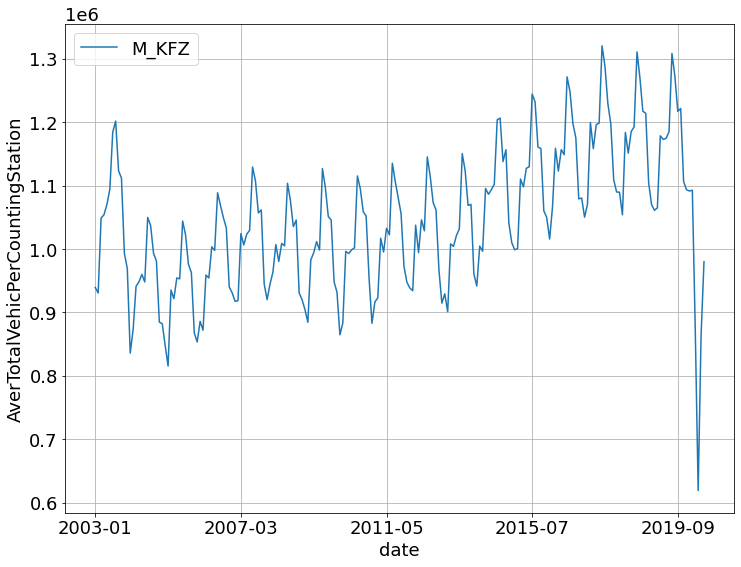

In [28]:
df_feature.plot(figsize=(12,9))
plt.grid()
plt.ylabel('AverTotalVehicPerCountingStation')

## Save feature as csv

In [29]:
df_feature.to_csv('../data/mobility/M_BastBaysisBastMR_Feature_Ger_Cor.csv')

## Difference of traffic in February 2020 in relation to February 2019 and 2018

In [30]:
diff_feb_20_17 = round(100 * (df_BAYSIS_BASTMR.PredGermany['2020-02']/df_BAYSIS_BASTMR.PredGermany['2017-02'] - 1),2)
diff_feb_20_18 = round(100 * (df_BAYSIS_BASTMR.PredGermany['2020-02']/df_BAYSIS_BASTMR.PredGermany['2018-02'] - 1),2)
diff_feb_20_19 = round(100 * (df_BAYSIS_BASTMR.PredGermany['2020-02']/df_BAYSIS_BASTMR.PredGermany['2019-02'] - 1),2)
print('Difference of traffic in Feb 2020 related to Feb 2017: ', diff_feb_20_17, '%')
print('Difference of traffic in Feb 2020 related to Feb 2018: ', diff_feb_20_18, '%')
print('Difference of traffic in Feb 2020 related to Feb 2019: ', diff_feb_20_19, '%')

Difference of traffic in Feb 2020 related to Feb 2017:  3.41 %
Difference of traffic in Feb 2020 related to Feb 2018:  4.75 %
Difference of traffic in Feb 2020 related to Feb 2019:  2.61 %


# Comparison to Tom Tom average traffic congestion of 25 cities in Germany

In [31]:
df_TT = pd.read_csv('../data/mobility/AverageOfCitiesGermanyTomTom_monthly.csv')
print(df_TT.head())

      date  M_TomTomAverageCityCongestion  M_TomTomAverageDiffRatio_20_To_29
0  2019-12                      18.180000                          -0.459112
1  2020-01                      26.954839                          -0.096639
2  2020-02                      27.853793                          -0.041748
3  2020-03                      20.891613                          -0.281790
4  2020-04                      16.240000                          -0.439753


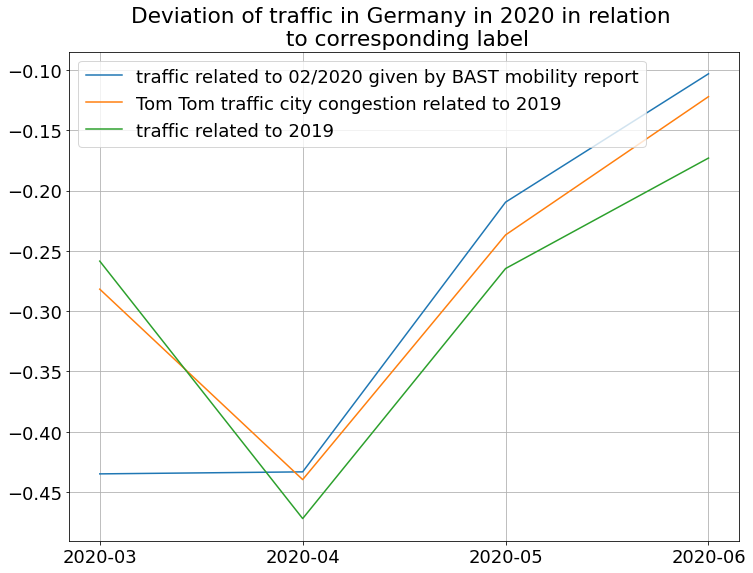

In [32]:
plt.figure(figsize=(12,9))
plt.plot(index, val_BAST_MR, label='traffic related to 02/2020 given by BAST mobility report')
plt.plot(index, df_TT.M_TomTomAverageDiffRatio_20_To_29[-4:], label='Tom Tom traffic city congestion related to 2019')
plt.plot(index, diff_20To19, label='traffic related to 2019')
plt.title('Deviation of traffic in Germany in 2020 in relation \n to corresponding label')
plt.legend()
plt.grid()